# Building Predictive models Classifier

In [1]:
import pandas as pd
import os
import numpy as np

def load_dataset(subfolder='', file='aapl.us.txt', data_type='raw', index_column=0):
    data_path = os.path.join(os.path.pardir, 'data', data_type, subfolder, file)
    print('Opening file ', data_path)
    df = pd.read_csv(data_path, index_col=index_column)
    print('%d missing values found' % df.isnull().sum().sum())
    return df

def generate_train_dataset(dataset, split_date='2016-01-01'):
    dataset_aux = dataset[dataset.Date < split_date]
    result_df = pd.DataFrame()
    result_df['Label'] = dataset_aux.Label
    result_df['Index'] = dataset_aux.index
    dataset_aux = dataset_aux.drop(columns=['Tomorrow_Date', 'Tomorrow_Open','Label','Diff_Tomorrow_Open','Date','Yesterday_Date']) 
    return dataset_aux, result_df


def generate_train_dataset_lowerbound(dataset, split_date='2016-01-01', lower_bound = '2000-01-01'):
    dataset_aux = dataset[(dataset.Date < split_date) & (dataset.Date > lower_bound)]
    result_df = pd.DataFrame()
    result_df['Label'] = dataset_aux.Label
    result_df['Index'] = dataset_aux.index
    dataset_aux = dataset_aux.drop(columns=['Tomorrow_Date', 'Tomorrow_Open','Label','Diff_Tomorrow_Open','Date','Yesterday_Date']) 
    return dataset_aux, result_df


def generate_test_dataset(dataset, split_date='2016-01-01'):
    dataset_aux = dataset[dataset.Date > split_date]
    result_df = pd.DataFrame()
    result_df['Label'] = dataset_aux.Label
    result_df['Index'] = dataset_aux.index
    dataset_aux = dataset_aux.drop(columns=['Tomorrow_Date', 'Tomorrow_Open','Label','Diff_Tomorrow_Open','Date','Yesterday_Date']) 
    return dataset_aux, result_df


# Prediction and metrics methods

In [2]:
import pandas as pd
import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.utils.multiclass import unique_labels

def create_predictions_dataset(test_df, model, X_test):
    predictions = model.predict(X_test)
    df_predicted = pd.DataFrame({ 'Label' : predictions, 'Index' : test_df.index} )
    return df_predicted


def compare_prediction_visual(df_predicted, df_real,model_name='Unknown model'):
    fig = figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    title = model_name + ' ' +  'classification results'
    df_predicted.plot(kind='scatter', x='Index',y='Label'`)
    plt.subplot(122)
    df_real.plot(kind='scatter', x='Index',y='Label',ax = plt.gca() ,title='Real classification results')
    plt.savefig('{0}.png'.format(model_name))


def get_model_metrics(model, y_test, X_test, model_name='Unknown model'):
    result = model.score(X_test, y_test)
    print ('Metrics for model: {}'.format(model_name))
    print ('\tScore: {1:.2f}'.format(model_name, result))
    print ('\tAccuracy: {0:.2f}'.format(accuracy_score(y_test, model.predict(X_test))))
    import warnings
    warnings.filterwarnings('ignore')
    print ('\tPrecision: {0:.2f}'.format(precision_score(y_test, model.predict(X_test))))
    print ('\tRecall: {0:.2f}'.format(recall_score(y_test, model.predict(X_test))))
    print ('\tPredicts {0:.2f}% time it the stock price goes up'.format(result*100, model_name))
    cm = confusion_matrix(y_test, model.predict(X_test))
    print( '\tConfusion matrix: \n\t{0} \n\t{1}'.format(cm[0], cm[1]))

In [3]:
import pandas as pd
import sklearn
sklearn.__version__
#from src.data.dataset_utils import load_dataset, write_dataset
#from src.features.feature_data import prepare_feture_vector


'0.21.3'

In [4]:
dataset = load_dataset(file='dataset_feature_vector.csv', data_type='processed')
train_df, result_train_df = generate_train_dataset_lowerbound(dataset)
test_df, result_test_df = generate_test_dataset(dataset)


Opening file  ../data/processed/dataset_feature_vector.csv
0 missing values found


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4023 entries, 3871 to 7893
Data columns (total 24 columns):
Yesterday_Open      4023 non-null float64
Yesterday_Close     4023 non-null float64
Yesterday_Volume    4023 non-null float64
Yesterday_Low       4023 non-null float64
Yesterday_High      4023 non-null float64
Open                4023 non-null float64
High                4023 non-null float64
Low                 4023 non-null float64
Close               4023 non-null float64
Volume              4023 non-null float64
OpenInt             4023 non-null float64
Average_High_Low    4023 non-null float64
Average_Day         4023 non-null float64
Diff_Close_Open     4023 non-null float64
Diff_Today_Open     4023 non-null float64
Diff_Today_Close    4023 non-null float64
Diff_Today_High     4023 non-null float64
Diff_Today_Low      4023 non-null float64
Month               4023 non-null int64
Year                4023 non-null int64
Day                 4023 non-null int64
Yesterday_Mont

In [6]:
X_train = train_df.values.astype('float')
y_train= result_train_df['Label'].ravel()

X_test = test_df.values.astype('float')
y_test = result_test_df['Label'].ravel()

print (y_train.shape)
print (X_train.shape)
print (y_test.shape)
print (X_test.shape)

(4023,)
(4023, 24)
(469,)
(469, 24)


In [7]:
## results descriptions 
print ('mean amount of increases in train : {0:.3f}'.format(np.mean(y_train)))
print ('total amount of increases in train : {}'.format(np.sum(y_train)))
print ('total amount of regiters in train : {}'.format(y_train.size))

mean amount of increases in train : 0.525
total amount of increases in train : 2113
total amount of regiters in train : 4023


### Build Baseline model

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.utils.multiclass import unique_labels

In [9]:
linear_model = DummyClassifier(strategy='most_frequent', random_state=0)

In [10]:
linear_model.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=0, strategy='most_frequent')

In [11]:
print ('Mean amount of increases in train : {0:.3f}.'.format(np.mean(y_train)))
print ('This means that the most frequent category is for the stock value to go up :)\n\n')
result = linear_model.score(X_test, y_test)
print ('Score for baseline model : {0:.2f}'.format(result))
print ('Baseline model predicts {0:.2f}% time it the stock price goes down'.format(result*100))
# accuracy score
print ('Accuracy for baseline model : {0:.2f}'.format(accuracy_score(y_test, linear_model.predict(X_test))))
# precision and recall scores
import warnings
warnings.filterwarnings('ignore')
print ('Precision for baseline model : {0:.2f}'.format(precision_score(y_test, linear_model.predict(X_test))))
print ('Recall for baseline model : {0:.2f}'.format(recall_score(y_test, linear_model.predict(X_test))))
cm = confusion_matrix(y_test, linear_model.predict(X_test))
print( 'Confusion matrix for baseline model: \n {0}'.format(cm))

Mean amount of increases in train : 0.525.
This means that the most frequent category is for the stock value to go up :)


Score for baseline model : 0.58
Baseline model predicts 58.00% time it the stock price goes down
Accuracy for baseline model : 0.58
Precision for baseline model : 0.58
Recall for baseline model : 1.00
Confusion matrix for baseline model: 
 [[  0 197]
 [  0 272]]


In [12]:
import matplotlib.pyplot as plt     
from matplotlib.pyplot import figure

labels = [0, 1]
cm = confusion_matrix(y_test, linear_model.predict(X_test), labels)
fig = figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()
cax = ax.matshow(cm)
plt.title('Confusion matrix using linear classifier')
fig.colorbar(cax)
ax.set_xticklabels(['']+ labels)
ax.set_yticklabels(['']+labels)
plt.xlabel('Predicted')
plt.ylabel('Actual value')
plt.show()

<Figure size 400x400 with 2 Axes>

In [13]:
get_model_metrics(linear_model, y_test, X_test, 'Linear model')

Metrics for model: Linear model
	Score: 0.58
	Accuracy: 0.58
	Precision: 0.58
	Recall: 1.00
	Predicts 58.00% time it the stock price goes up
	Confusion matrix: 
	[  0 197] 
	[  0 272]


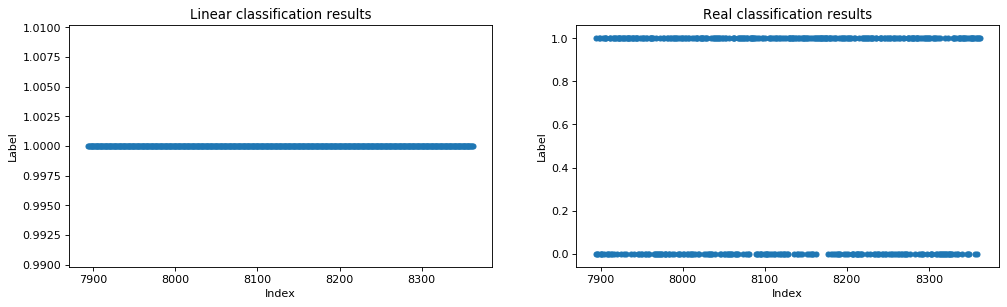

In [14]:
compare_prediction_visual(create_predictions_dataset(test_df, linear_model,X_test), result_test_df, 'Linear')

### Logistic Regression Model

In [15]:
# import function
from sklearn.linear_model import LogisticRegression

In [16]:
# create model
logistic_model = LogisticRegression(random_state=0, solver='liblinear')

In [17]:
# train model
logistic_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
get_model_metrics(logistic_model, y_test, X_test, 'Logistic model')

Metrics for model: Logistic model
	Score: 0.58
	Accuracy: 0.58
	Precision: 0.58
	Recall: 1.00
	Predicts 57.78% time it the stock price goes up
	Confusion matrix: 
	[  0 197] 
	[  1 271]


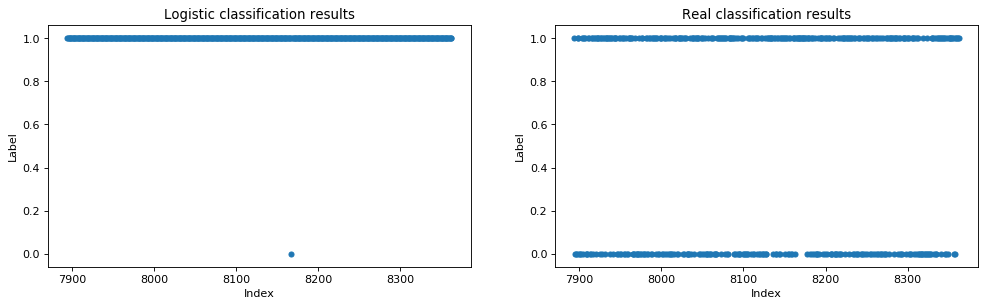

In [19]:
compare_prediction_visual(create_predictions_dataset(test_df, logistic_model,X_test), result_test_df, 'Logistic')

# Hyperparam optimization

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [21]:
#This takes several minutes
parameters = {'C':[50.0],'class_weight' : ['balanced'], 'max_iter' : [100]}
logistic_model_grid = GridSearchCV(logistic_model, param_grid=parameters, cv=3)

with ignore_warnings(category=ConvergenceWarning):
    logistic_model_grid.fit(X_train, y_train)
    
print ('Best parameters for logistic model grid {}'.format(logistic_model_grid.best_params_))

Best parameters for logistic model grid {'C': 50.0, 'class_weight': 'balanced', 'max_iter': 100}


Best score : 0.48
Score for logistic regression - version 2 : 0.47
Metrics for model: Logistic model grid
	Score: 0.47
	Accuracy: 0.47
	Precision: 0.57
	Recall: 0.35
	Predicts 46.91% time it the stock price goes up
	Confusion matrix: 
	[124  73] 
	[176  96]


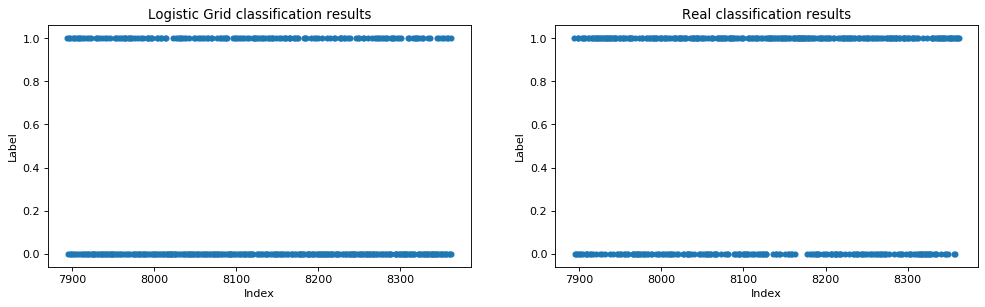

In [22]:

print ('Best score : {0:.2f}'.format(logistic_model_grid.best_score_))
print ('Score for logistic regression - version 2 : {0:.2f}'.format(logistic_model_grid.score(X_test, y_test)))

get_model_metrics(logistic_model_grid, y_test, X_test, 'Logistic model grid')
compare_prediction_visual(create_predictions_dataset(test_df, logistic_model_grid, X_test), result_test_df, 'Logistic Grid')

# Using prophet simple

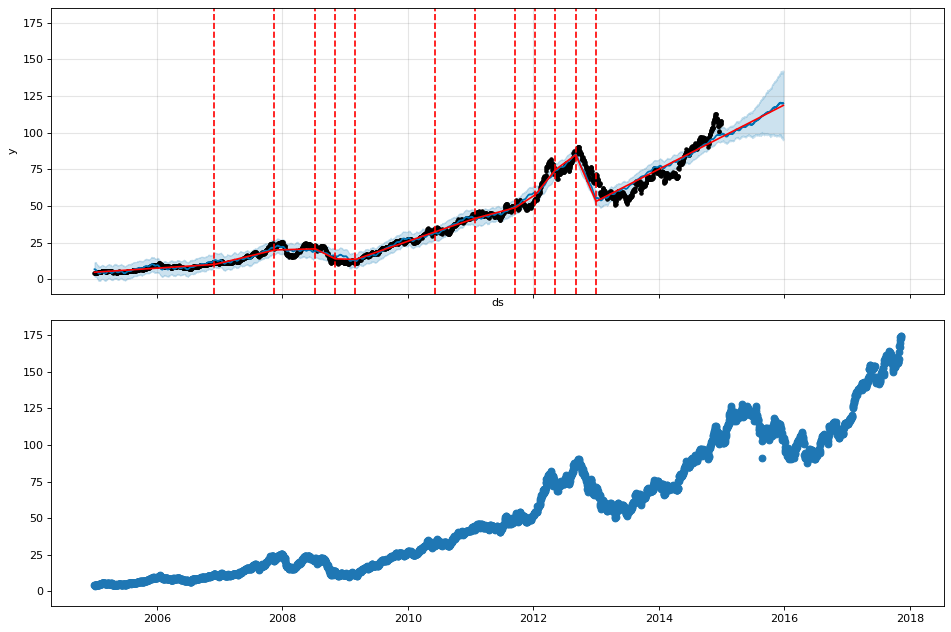

In [160]:
prophet = Prophet(daily_seasonality=False)
prophet.fit(prophet_train)
future = prophet.make_future_dataframe(periods=360, freq='d')
forecast = prophet.predict(future)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, sharex=True, num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
prophet.plot(forecast, ax=ax1)
a = add_changepoints_to_plot(ax1, prophet, forecast)
ax2.scatter(x=prophet_df.ds, y=prophet_df.y)
plt.show()

In [266]:
df_cv = cross_validation(
    prophet_logistic, initial='1000 days', period='720 days',horizon = '720 days')
print (df_cv)


INFO:fbprophet:Making 5 forecasts with cutoffs between 2008-01-01 00:00:00 and 2015-11-20 00:00:00


             ds       yhat  yhat_lower  yhat_upper        y     cutoff
0    2008-01-02  25.244358   24.608096   25.890345   25.547 2008-01-01
1    2008-01-03  25.296840   24.635958   25.963208   25.034 2008-01-01
2    2008-01-04  25.349408   24.671078   26.013330   24.527 2008-01-01
3    2008-01-07  25.507636   24.821193   26.165360   23.213 2008-01-01
4    2008-01-08  25.560553   24.875782   26.271012   23.060 2008-01-01
...         ...        ...         ...         ...      ...        ...
2479 2017-11-03  15.168471    0.488555  108.172301  173.380 2015-11-20
2480 2017-11-06  14.996278   -0.183071  107.402079  171.750 2015-11-20
2481 2017-11-07  14.939267    0.453924  107.933044  173.290 2015-11-20
2482 2017-11-08  14.882449    0.393308  106.953836  174.030 2015-11-20
2483 2017-11-09  14.825824    0.446191  108.116649  174.480 2015-11-20

[2484 rows x 6 columns]


In [280]:
value = df_cv['cutoff'].unique()[1] - df_cv['cutoff'].unique()[0]
x = np.timedelta64(value, 'ns')
days = x.astype('int')
days
# print ("{} {} {}".format(df_cv['cutoff'].unique()[0],df_cv['cutoff'].unique()[1],(df_cv['cutoff'].unique()[1] - df_cv['cutoff'].unique()[0])/3600/1000/24))
# print(prophet_df[prophet_df.ds == prophet_df.ds.min()])
# print(prophet_df[prophet_df.ds == prophet_df.ds.max()])
# df_cv['cutoff'].unique()

62208000000000000

In [257]:

cutoff = df_cv['cutoff'].unique()[0]
print(df_cv['cutoff'].unique())
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

df_p = performance_metrics(df_cv)
df_p.head()

['2013-11-30T00:00:00.000000000' '2015-11-20T00:00:00.000000000']


,horizon,mse,rmse,mae,mape,coverage
0,73 days,27.382017,5.232783,4.048561,0.057850,0.591837
1,74 days,28.136865,5.304419,4.128462,0.058992,0.571429
2,75 days,29.010821,5.386169,4.217720,0.060274,0.551020
3,76 days,29.520825,5.433307,4.270275,0.061036,0.551020
4,80 days,29.877595,5.466040,4.304282,0.061554,0.551020


#### The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), and coverage of the yhat_lower and yhat_upper estimates. These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

            ds        yhat  yhat_lower  yhat_upper        y     cutoff
0   2013-12-02   71.137953   68.227281   74.095446   73.904 2013-11-30
1   2013-12-03   71.236166   68.079001   74.250117   73.945 2013-11-30
2   2013-12-04   71.334392   68.118594   74.549898   74.899 2013-11-30
3   2013-12-05   71.432630   68.463756   74.617175   75.845 2013-11-30
4   2013-12-06   71.530881   68.471362   74.670243   74.937 2013-11-30
..         ...         ...         ...         ...      ...        ...
493 2015-11-16  128.201129   16.740883  149.056755  107.230 2013-11-30
494 2015-11-17  128.250005   17.351329  149.337443  110.630 2013-11-30
495 2015-11-18  128.298789   16.715317  149.210185  111.450 2013-11-30
496 2015-11-19  128.347483   16.478057  149.450261  113.250 2013-11-30
497 2015-11-20  128.396085   17.056728  149.632296  114.770 2013-11-30

[498 rows x 6 columns]


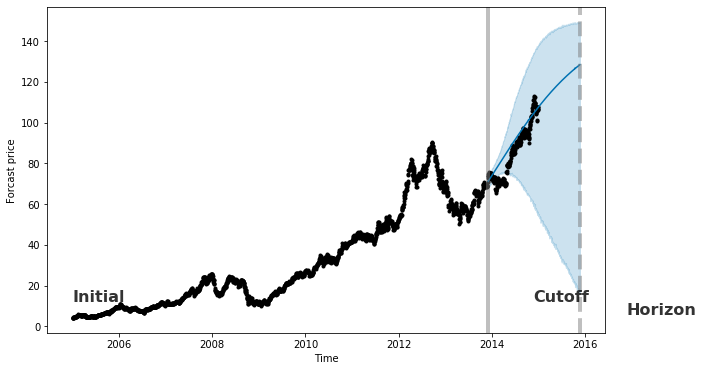

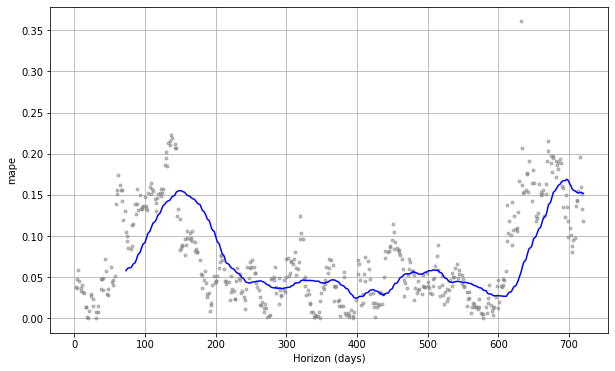

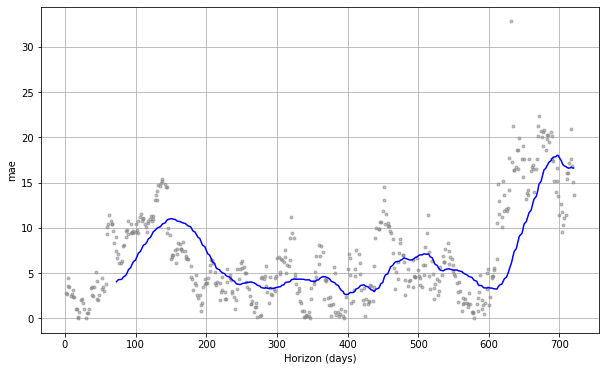

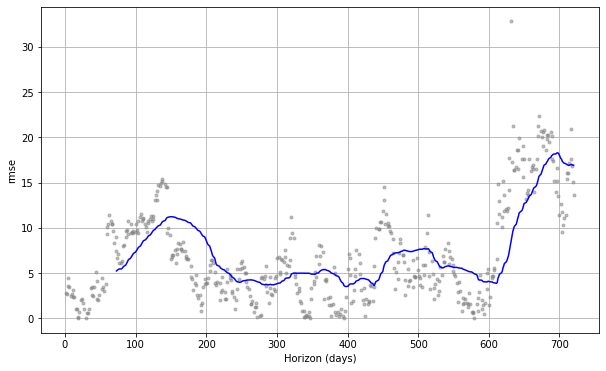

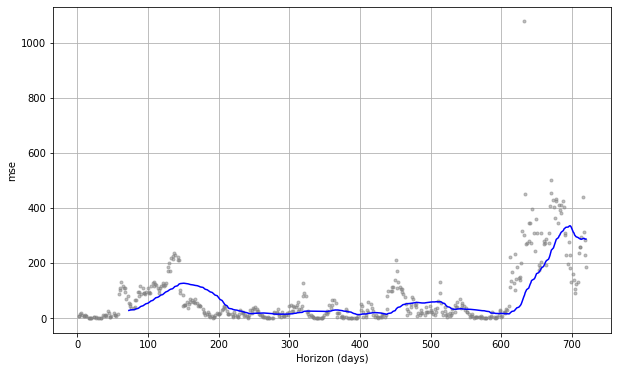

In [236]:

def plot_prophet_cross_validation_results(model, df_cv,initial='2005-01-01', cutoffStr='2014-11-20'):
    fig = plt.figure(facecolor='w', figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(model.history['ds'].values, model.history['y'], 'k.')
    ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
    ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
    ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
    ax.set_ylabel('Forcast price')
    ax.set_xlabel('Time')
    ax.text(x=pd.to_datetime(initial),y=12, s='Initial', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
    ax.text(x=pd.to_datetime(cutoffStr),y=12, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
    ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('720 days'), c='gray', lw=4,
       alpha=0.5, ls='--')
    ax.text(x=pd.to_datetime('2016-11-19'),y=6, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8);


plot_prophet_cross_validation_results(prophet_logistic, df_cv,'2005-01-01')
print(df_cv)
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mape')
fig = plot_cross_validation_metric(df_cv, metric='mae')
fig = plot_cross_validation_metric(df_cv, metric='rmse')
fig = plot_cross_validation_metric(df_cv, metric='mse')



# Generate scripts to run on google cloud

In [29]:
logistic_model_script_file = os.path.join(os.path.pardir,'src','models','logistic_model.py')
print(logistic_model_script_file)
prediction_utils_script_file = os.path.join(os.path.pardir,'src','models','prediction_utils.py')
print(prediction_utils_script_file)


../src/models/logistic_model.py
../src/models/prediction_utils.py


In [30]:
%%writefile $logistic_model_script_file
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import src.models.prediction_utils as utils

X_train, y_train, result_train_df = utils.create_train_matrix('dataset_feature_vector.csv')
X_test, y_test, result_test_df = utils.create_test_matrix('dataset_feature_vector.csv')

#Create model/estimator
logistic_model = LogisticRegression(random_state=0, solver='liblinear')

#This takes several minutes
parameters = {'C':[1.0, 10.0, 50.0, 100.0, 1000.0], 'penalty' : ['l1','l2'],'class_weight' : ['balanced',None], 'solver' : ['liblinear','saga'], 'max_iter' : [100,1000,10000]}
logistic_model_grid = GridSearchCV(logistic_model, param_grid=parameters, cv=3)
#Train every posible variation of the model
with ignore_warnings(category=ConvergenceWarning):
    logistic_model_grid.fit(X_train, y_train)

#Get the best    
print ('Best parameters for logistic model grid {}'.format(logistic_model_grid.best_params_))
print ('Best score : {0:.2f}'.format(logistic_model_grid.best_score_))
print ('Score for logistic regression - version 2 : {0:.2f}'.format(logistic_model_grid.score(X_test, y_test)))

utils.get_model_metrics(logistic_model_grid, y_test, X_test, 'Logistic model grid')
utils.compare_prediction_visual(utils.create_predictions_dataset(result_test_df, logistic_model_grid, X_test), result_test_df, 'Logistic Grid')




Overwriting ../src/models/logistic_model.py


In [31]:
%%writefile $prediction_utils_script_file
import pandas as pd
import warnings
import sklearn
import datetime
import matplotlib.pyplot as plt     
from matplotlib.pyplot import figure
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.utils.multiclass import unique_labels

import src.data.dataset_utils as utils
import src.data.processed_data as process

def create_predictions_dataset(test_df, model, X_test):
    predictions = model.predict(X_test)
    df_predicted = pd.DataFrame({ 'Label' : predictions, 'Index' : test_df.index} )
    return df_predicted


def compare_prediction_visual(df_predicted, df_real,model_name='Unknown model'):
    fig = figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    title = model_name + ' ' +  'classification results'
    df_predicted.plot(kind='scatter', x='Index',y='Label',ax = plt.gca(),title=title)
    plt.subplot(122)
    df_real.plot(kind='scatter', x='Index',y='Label',ax = plt.gca() ,title='Real classification results')
    today = datetime.date.today()
    plt.savefig('{0}{1}.png'.format(model_name,today))


def get_model_metrics(model, y_test, X_test, model_name='Unknown model'):
    result = model.score(X_test, y_test)
    print ('Metrics for model: {}'.format(model_name))
    print ('\tScore: {1:.2f}'.format(model_name, result))
    print ('\tAccuracy: {0:.2f}'.format(accuracy_score(y_test, model.predict(X_test))))
    warnings.filterwarnings('ignore')
    print ('\tPrecision: {0:.2f}'.format(precision_score(y_test, model.predict(X_test))))
    print ('\tRecall: {0:.2f}'.format(recall_score(y_test, model.predict(X_test))))
    print ('\tPredicts {0:.2f}% time it the stock price goes up'.format(result*100, model_name))
    cm = confusion_matrix(y_test, model.predict(X_test))
    print( '\tConfusion matrix: \n\t{0} \n\t{1}'.format(cm[0], cm[1]))

    
def create_train_matrix(file, data_type='processed', predicted_variable='Label'):
    dataset = utils.load_dataset('',file, data_type)
    train_df, result_train_df = process.generate_train_dataset_lowerbound(dataset)
    X_train = train_df.values.astype('float')
    y_train = result_train_df[predicted_variable].ravel()
    print (y_train.shape)
    print (X_train.shape)
    
    return X_train, y_train, result_train_df


def create_test_matrix(file, data_type='processed', predicted_variable='Label'):
    dataset = utils.load_dataset('',file, data_type)
    test_df, result_test_df = process.generate_test_dataset(dataset)
    X_test = test_df.values.astype('float')
    y_test = result_test_df['Label'].ravel()
    print (y_test.shape)
    print (X_test.shape)
    
    return X_test, y_test, result_test_df


    

Overwriting ../src/models/prediction_utils.py
